# Multivariate TSMOM

In [1]:
import sys
sys.path.append('../')

from miquants_demo.data_collection.PriceLoader import load_stock_data,load_index_data
from miquants_demo.selection import TSMOM
from miquants_demo.utils.metrics import calc_performance_metrics_subset,calc_sharpe_by_year


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from empyrical import stats
import seaborn as sns

In [94]:
stock_list = ['VCB','HPG','FPT','MWG']

In [95]:
stock = pd.DataFrame()
for symbol in stock_list:
    df = load_stock_data(symbol,'2016-01-01','2023-02-28')
    stock[symbol] = df.close
    
stock.index = pd.to_datetime(stock.index)
vnindex = load_index_data('VNINDEX','2016-01-01','2023-02-28')
vnindex.index = pd.to_datetime(vnindex.index)
vnindex['vnindex'] = vnindex['close']
vnindex=vnindex['vnindex'].pct_change()
vnindex.index = pd.to_datetime(vnindex.index)

stock

,VCB,HPG,FPT,MWG
tradingDate,,,,
2016-01-04,23073.0,3789.0,13944.0,9096.0
2016-01-05,22699.0,3750.0,13944.0,9096.0
2016-01-06,22966.0,3816.0,13974.0,9038.0
2016-01-07,22699.0,3711.0,13711.0,8750.0
2016-01-08,22539.0,3645.0,13507.0,8635.0
...,...,...,...,...
2023-02-22,93000.0,21200.0,81800.0,43000.0
2023-02-23,93300.0,21500.0,81400.0,43000.0
2023-02-24,93500.0,20800.0,80800.0,42100.0


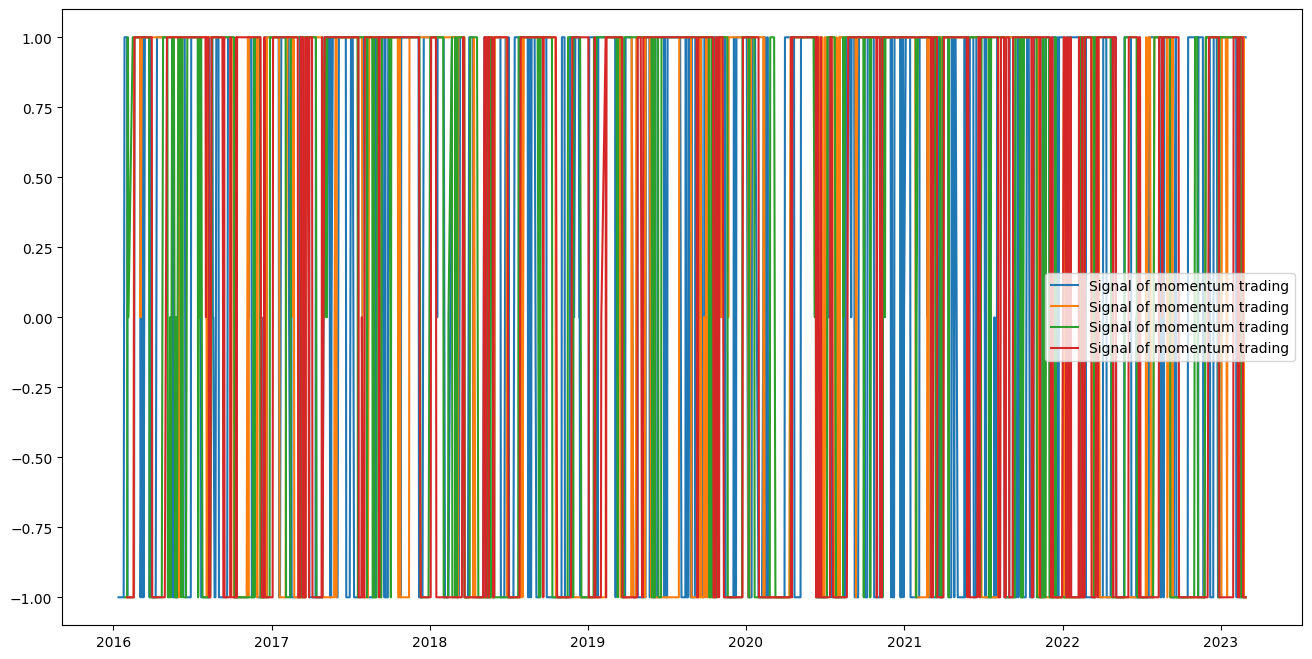

In [96]:
old_school_est = TSMOM.trend_estimation.old_school_estimate
trend_combinations = [7,20,18,21]

old_school = pd.DataFrame()
signal = pd.DataFrame()
for symbol,ts_length in zip(stock_list,trend_combinations):
    old_school = old_school_est(stock[symbol],TS_LENGTH=ts_length)
    signal[symbol] = TSMOM.trading_signal.sign_func(old_school)

fig,ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(signal,label='Signal of momentum trading')
plt.legend()
plt.show()

In [97]:
returns_df = pd.DataFrame()
for symbol in stock_list:
    print(symbol)
    tsmom = TSMOM.TSMOM(stock[symbol],signal[symbol],long_only=True,VOL_TARGET=0.35,transaction_fee=0.001)
    returns_df[symbol] = tsmom.run()
returns_df.index = pd.to_datetime(returns_df.index)

VCB
HPG
FPT
MWG


In [98]:
corr = stock.pct_change().corr()
corr.style.background_gradient(cmap='coolwarm')

,VCB,HPG,FPT,MWG
VCB,1.000000,0.425478,0.432543,0.371594
HPG,0.425478,1.000000,0.479692,0.443997
FPT,0.432543,0.479692,1.000000,0.538478
MWG,0.371594,0.443997,0.538478,1.000000


In [99]:
corr = returns_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,VCB,HPG,FPT,MWG
VCB,1.000000,0.221914,0.188198,0.151449
HPG,0.221914,1.000000,0.268981,0.193468
FPT,0.188198,0.268981,1.000000,0.351523
MWG,0.151449,0.193468,0.351523,1.000000


In [100]:
total_returns = returns_df.sum(axis=1)/len(stock_list)

In [101]:
compare=pd.DataFrame()
compare['multivariate_TSMOM'] = total_returns
compare['vnindex'] = vnindex
compare.fillna(0,inplace=True)
compare

,multivariate_TSMOM,vnindex
tradingDate,,
2016-01-04,0.000000,0.000000
2016-01-05,0.000000,-0.007782
2016-01-06,0.000000,0.008124
2016-01-07,0.000000,-0.016029
2016-01-08,0.000000,-0.009392
...,...,...
2023-02-22,-0.000199,-0.025826
2023-02-23,-0.005420,-0.000588
2023-02-24,-0.002376,-0.013382


In [102]:
stats.cum_returns(compare)

,multivariate_TSMOM,vnindex
tradingDate,,
2016-01-04,0.000000,0.000000
2016-01-05,0.000000,-0.007782
2016-01-06,0.000000,0.000279
2016-01-07,0.000000,-0.015755
2016-01-08,0.000000,-0.025000
...,...,...
2023-02-22,7.437328,0.835414
2023-02-23,7.391600,0.834334
2023-02-24,7.371658,0.809787


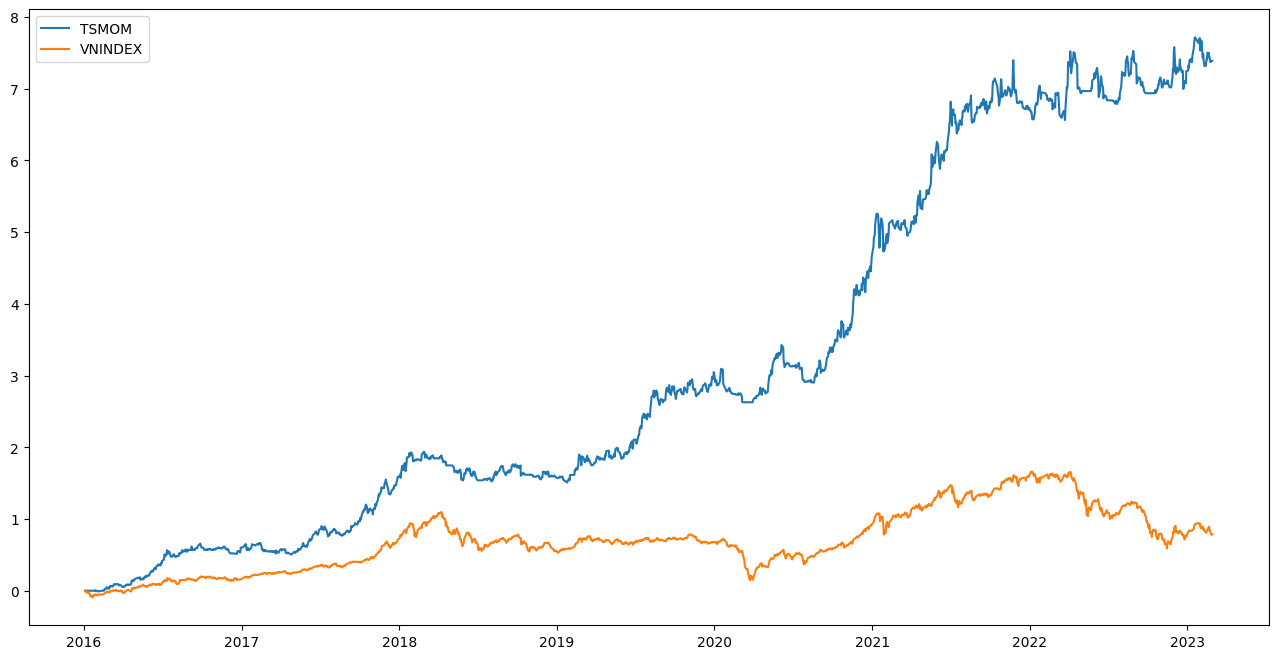

In [103]:
fig,ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(stats.cum_returns(compare.multivariate_TSMOM),label='TSMOM')
ax.plot(stats.cum_returns(compare.vnindex),label='VNINDEX')
plt.legend()
plt.show()

In [104]:
xxx = calc_performance_metrics_subset(compare)
metrics = pd.DataFrame({'Annual return':xxx['annual_return'],'Annual volatility':xxx['annual_volatility'],'Downside risk':xxx['downside_risk'],'Max drawdown':xxx['max_drawdown'].to_list()})
metrics = metrics.applymap("{0:.2%}".format)
metrics.T

,multivariate_TSMOM,vnindex
Annual return,34.96%,8.50%
Annual volatility,17.74%,18.90%
Downside risk,11.61%,14.27%
Max drawdown,14.65%,45.26%


In [105]:
x1 = calc_sharpe_by_year(compare[['multivariate_TSMOM']].rename(columns={'multivariate_TSMOM':'captured_returns'}))
x2 = calc_sharpe_by_year(compare[['vnindex']].rename(columns={'vnindex':'captured_returns'}))
sharpe_df = pd.DataFrame({'multivariate tsmom':x1,'vnindex':x2})
sharpe_df[:-1]

,multivariate tsmom,vnindex
sharpe_ratio_2016,2.967055,1.120605
sharpe_ratio_2017,2.677202,4.066538
sharpe_ratio_2018,0.091323,-0.332813
sharpe_ratio_2019,2.491713,0.741142
sharpe_ratio_2020,1.907042,0.723412
sharpe_ratio_2021,1.668007,1.567952
sharpe_ratio_2022,0.510742,-1.493727


In [106]:
import scipy

ts1 = compare['multivariate_TSMOM']
## ts2: return of TSMOM with higher fee
ts2 =compare['vnindex']
## ts3: return of TSMOM without vol target

statistics = scipy.stats.describe(ts1)
statistics1 = scipy.stats.describe(ts2)


moment_compare = pd.DataFrame(index=['mean','std','skewness','kurtosis'],columns=['multivariate tsmom','VNINDEX'])
moment_compare.loc['mean',:]=round(statistics.mean,4),round(statistics1.mean,4)
moment_compare.loc['std',:]=round(np.sqrt(statistics.variance),4),round(np.sqrt(statistics1.variance),4)
moment_compare.loc['skewness',:]=round(statistics.skewness,4),round(statistics1.skewness,4)
moment_compare.loc['kurtosis',:]=round(statistics.kurtosis,4),round(statistics1.kurtosis,4)
moment_compare

,multivariate tsmom,VNINDEX
mean,0.0013,0.0004
std,0.0112,0.0119
skewness,-0.1797,-0.8681
kurtosis,3.0501,4.2508


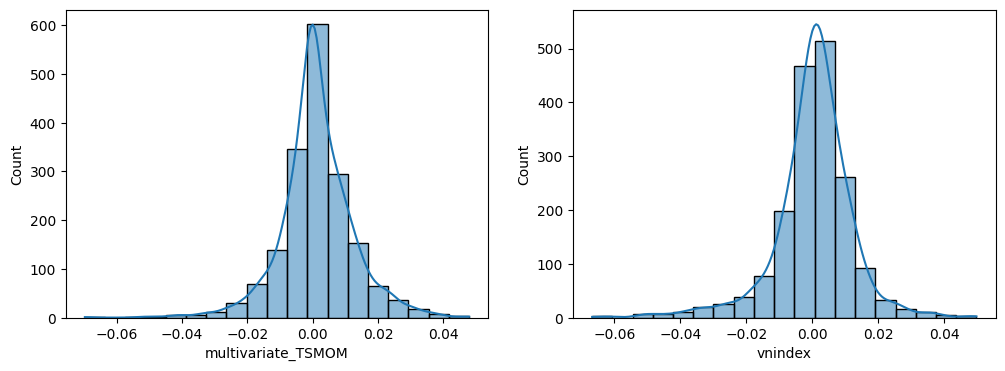

In [107]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
bins = 19
sns.histplot(ts1,bins=bins,kde=True,ax=ax1)
# ax1.title.set_text('TSMOM')

sns.histplot(ts2,bins=bins,kde=True,ax=ax2)
# ax2.title.set_text('TSMOM with higher')

plt.show()

In [108]:
def winTrade_prob(k3):
    val = 1/2 - (k3/(6*np.sqrt(2*np.pi)))
    return val

print(f'{stock_list} || TSMOM win trades probability :',"{:.2%}".format(winTrade_prob(statistics1.skewness)))

['VCB', 'HPG', 'FPT', 'MWG'] || TSMOM win trades probability : 55.77%


## T+3

In [168]:
stock = pd.DataFrame()
for symbol in stock_list:
    df = load_stock_data(symbol,'2016-01-01','2023-02-28')
    stock[symbol] = df.close
    
stock.index = pd.to_datetime(stock.index)
vnindex = load_index_data('VNINDEX','2016-01-01','2023-02-28')
vnindex.index = pd.to_datetime(vnindex.index)

stock = stock.resample('3D',origin='end').last()
vnindex = vnindex.resample('3D',origin='end').last()


vnindex['vnindex'] = vnindex['close']
vnindex=vnindex['vnindex'].pct_change()
vnindex.index = pd.to_datetime(vnindex.index)

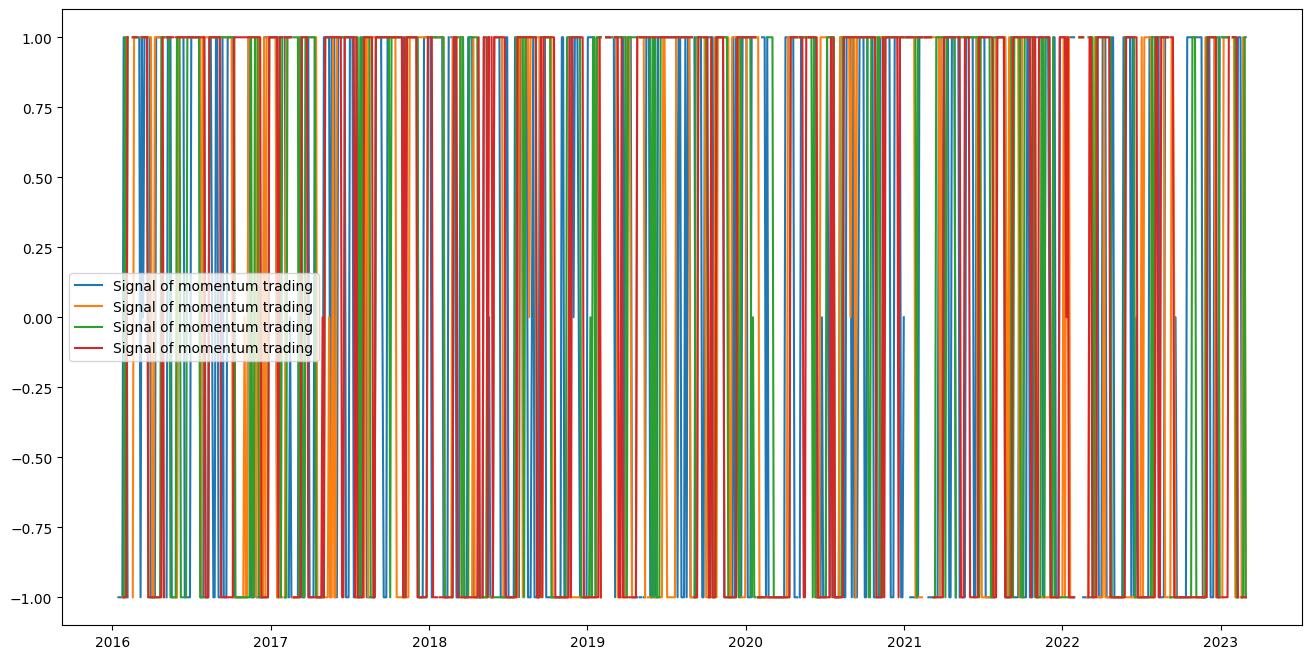

In [169]:
old_school_est = TSMOM.trend_estimation.old_school_estimate
trend_combinations = [3,6,7,7,7]
old_school = pd.DataFrame()
signal = pd.DataFrame()
for symbol,ts_length in zip(stock_list,trend_combinations):
    old_school = old_school_est(stock[symbol],TS_LENGTH=ts_length)
    signal[symbol] = TSMOM.trading_signal.sign_func(old_school)

fig,ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(signal,label='Signal of momentum trading')
plt.legend()
plt.show()

In [170]:
returns_df = pd.DataFrame()
for symbol in stock_list:
    print(symbol)
    tsmom = TSMOM.TSMOM(stock[symbol],signal[symbol],long_only=True,VOL_TARGET=0.35,transaction_fee=0.001,T_3=True)
    returns_df[symbol] = tsmom.run()
returns_df.index = pd.to_datetime(returns_df.index)

VCB
HPG
FPT
MWG


In [171]:
corr = stock.pct_change().corr()
corr.style.background_gradient(cmap='coolwarm')

,VCB,HPG,FPT,MWG
VCB,1.000000,0.431315,0.403091,0.369236
HPG,0.431315,1.000000,0.432949,0.447360
FPT,0.403091,0.432949,1.000000,0.501100
MWG,0.369236,0.447360,0.501100,1.000000


In [172]:
corr = returns_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,VCB,HPG,FPT,MWG
VCB,1.000000,0.130059,0.170190,0.140521
HPG,0.130059,1.000000,0.254098,0.179459
FPT,0.170190,0.254098,1.000000,0.272107
MWG,0.140521,0.179459,0.272107,1.000000


In [173]:
total_returns = returns_df.sum(axis=1)/len(stock_list)

In [174]:
compare=pd.DataFrame()
compare['multivariate_TSMOM'] = total_returns
compare['vnindex'] = vnindex
compare.fillna(0,inplace=True)
compare

,multivariate_TSMOM,vnindex
tradingDate,,
2016-01-06,0.000000,0.000000
2016-01-09,0.000000,-0.025271
2016-01-12,0.000000,0.007517
2016-01-15,0.000000,-0.037607
2016-01-18,0.000000,-0.030698
...,...,...
2023-02-16,0.002180,0.013979
2023-02-19,-0.000325,0.000964
2023-02-22,-0.004216,-0.004748


In [175]:
stats.cum_returns(compare)

,multivariate_TSMOM,vnindex
tradingDate,,
2016-01-06,0.000000,0.000000
2016-01-09,0.000000,-0.025271
2016-01-12,0.000000,-0.017944
2016-01-15,0.000000,-0.054876
2016-01-18,0.000000,-0.083889
...,...,...
2023-02-16,9.068911,0.841882
2023-02-19,9.065635,0.843657
2023-02-22,9.023197,0.834903


In [176]:
help(stats.annual_return)

Help on function annual_return in module empyrical.stats:

annual_return(returns, period='daily', annualization=None)
    Determines the mean annual growth rate of returns. This is equivilent
    to the compound annual growth rate.
    
    Parameters
    ----------
    returns : pd.Series or np.ndarray
        Periodic returns of the strategy, noncumulative.
        - See full explanation in :func:`~empyrical.stats.cum_returns`.
    period : str, optional
        Defines the periodicity of the 'returns' data for purposes of
        annualizing. Value ignored if `annualization` parameter is specified.
        Defaults are::
    
            'monthly':12
            'weekly': 52
            'daily': 252
    
    annualization : int, optional
        Used to suppress default values available in `period` to convert
        returns into annual returns. Value should be the annual frequency of
        `returns`.
    
    Returns
    -------
    annual_return : float
        Annual Return as 

In [177]:
stats.annual_return(compare, annualization=360)

multivariate_TSMOM    1.580436
vnindex               0.270118
dtype: float64

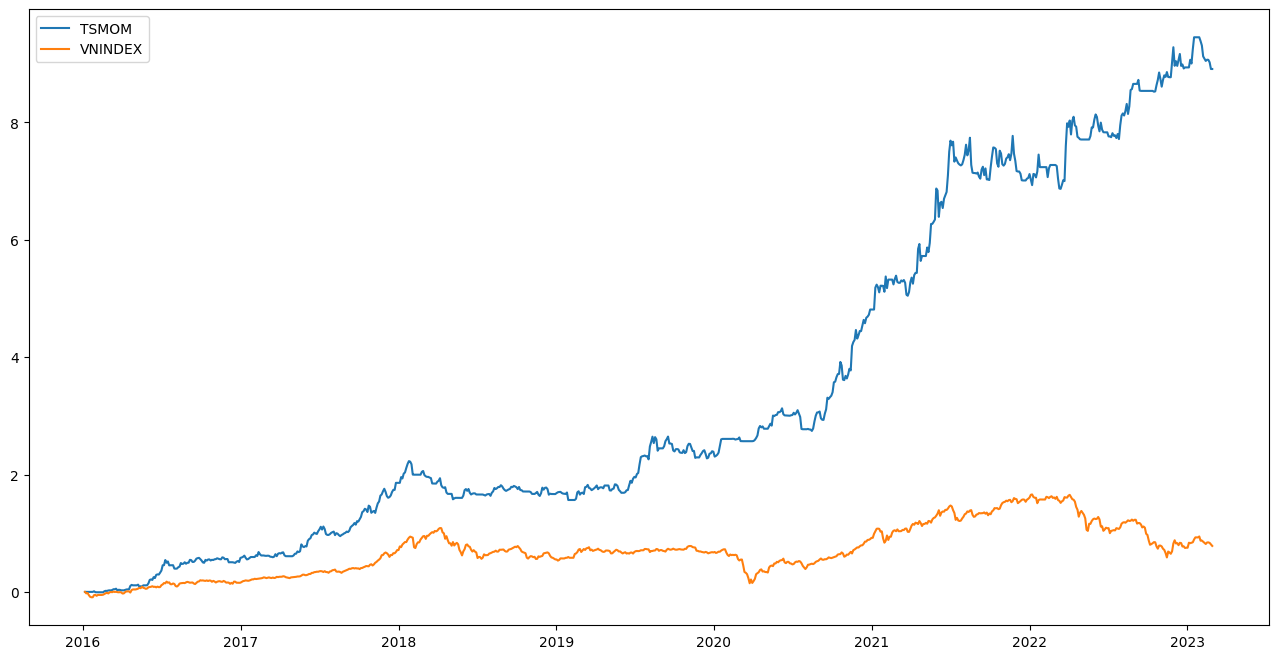

In [178]:
fig,ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(stats.cum_returns(compare.multivariate_TSMOM),label='TSMOM')
ax.plot(stats.cum_returns(compare.vnindex),label='VNINDEX')
plt.legend()
plt.show()

In [179]:
xxx = calc_performance_metrics_subset(compare.resample('D').asfreq().fillna(0))
metrics = pd.DataFrame({'Annual return':xxx['annual_return'],'Annual volatility':xxx['annual_volatility'],'Downside risk':xxx['downside_risk'],'Max drawdown':xxx['max_drawdown'].to_list()})
metrics = metrics.applymap("{0:.2%}".format)
metrics.T

,multivariate_TSMOM,vnindex
Annual return,24.78%,5.74%
Annual volatility,15.68%,15.69%
Downside risk,9.06%,11.53%
Max drawdown,20.51%,45.06%


In [180]:
x1 = calc_sharpe_by_year(compare[['multivariate_TSMOM']].rename(columns={'multivariate_TSMOM':'captured_returns'}))
x2 = calc_sharpe_by_year(compare[['vnindex']].rename(columns={'vnindex':'captured_returns'}))
sharpe_df = pd.DataFrame({'multivariate tsmom':x1,'vnindex':x2})
sharpe_df[:-1]

,multivariate tsmom,vnindex
sharpe_ratio_2016,3.493516,1.517838
sharpe_ratio_2017,4.458481,6.031485
sharpe_ratio_2018,-0.558465,-0.470260
sharpe_ratio_2019,1.925014,1.010950
sharpe_ratio_2020,4.321485,1.010682
sharpe_ratio_2021,2.238188,2.412998
sharpe_ratio_2022,2.056641,-2.068529


In [181]:
import scipy

ts1 = compare['multivariate_TSMOM']
## ts2: return of TSMOM with higher fee
ts2 =compare['vnindex']
## ts3: return of TSMOM without vol target

statistics = scipy.stats.describe(ts1)
statistics1 = scipy.stats.describe(ts2)


moment_compare = pd.DataFrame(index=['mean','std','skewness','kurtosis'],columns=['multivariate tsmom','VNINDEX'])
moment_compare.loc['mean',:]=round(statistics.mean,4),round(statistics1.mean,4)
moment_compare.loc['std',:]=round(np.sqrt(statistics.variance),4),round(np.sqrt(statistics1.variance),4)
moment_compare.loc['skewness',:]=round(statistics.skewness,4),round(statistics1.skewness,4)
moment_compare.loc['kurtosis',:]=round(statistics.kurtosis,4),round(statistics1.kurtosis,4)
moment_compare

,multivariate tsmom,VNINDEX
mean,0.0028,0.0008
std,0.017,0.0171
skewness,0.5425,-0.6204
kurtosis,3.2176,4.0292


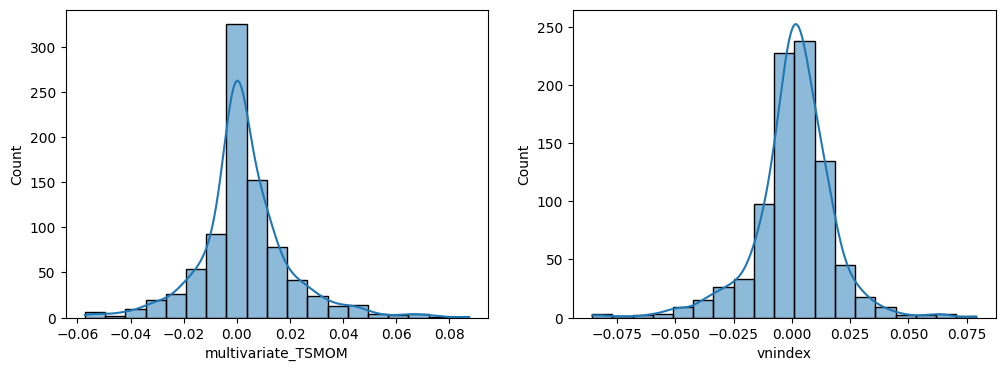

In [182]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
bins = 19
sns.histplot(ts1,bins=bins,kde=True,ax=ax1)
# ax1.title.set_text('TSMOM')

sns.histplot(ts2,bins=bins,kde=True,ax=ax2)
# ax2.title.set_text('TSMOM with higher')

plt.show()

In [183]:
print(f'{stock_list} || TSMOM win trades probability :',"{:.2%}".format(winTrade_prob(statistics1.skewness)))

['VCB', 'HPG', 'FPT', 'MWG'] || TSMOM win trades probability : 54.13%
